<a href="https://colab.research.google.com/github/AmirulAzizi2225/AI4EO-Final-Project/blob/main/Final_Project_AI4EO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land Use and Land Cover (LULC) Classification using ESA Sentinel-3 Imagery


In [1]:
# Mount colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install plug-in pandas
!pip install requests shapely pandas

In [3]:
import requests
import pandas as pd
import os

## Data acquisition from Sentinel-3 Satellite

In [ ]:
def get_access_and_refresh_token(username, password):
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "cdse-public",
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    tokens = response.json()
    return tokens["access_token"], tokens["refresh_token"]

# ESA Sentinel-3 credentials
username = "amirul.azizi.22@ucl.ac.uk"
password = "Haziqcopernicus02_"
access_token, refresh_token = get_access_and_refresh_token(username, password)


In [ ]:
def query_sentinel3_olci_data(start_date, end_date, polygon, token):
    filter_string = (
        f"Collection/Name eq 'SENTINEL-3' and "
        f"Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/Value eq 'OL_1_EFR___') and "
        f"ContentDate/Start gt {start_date}T00:00:00.000Z and ContentDate/Start lt {end_date}T23:59:59.999Z"
    )

    url = (
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
        f"$filter={filter_string} and "
        f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}')&"
        f"$top=1000"
    )

    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    data = response.json()["value"]

    return pd.DataFrame(data)

# For this project, I selected region within the Greater London
polygon = "POLYGON((-0.51 51.28, -0.51 51.7, 0.33 51.7, 0.33 51.28, -0.51 51.28))"

# 2 full months of time-frame from early June to end of July 2023
start_date = "2023-06-01"
end_date = "2023-07-31"

# Fetch Sentinel-3 OLCI data for specified Area of Interest AOI and date range
sentinel3_data = query_sentinel3_olci_data(start_date, end_date, polygon, access_token)

# Display fetched metadata
print(sentinel3_data.head())


    @odata.mediaContentType                                    Id  \
0  application/octet-stream  baa6c1f5-f67e-4ea5-93aa-b9d5c977f765   
1  application/octet-stream  5a2ed76d-2eef-4d46-a5c5-fcc97e2da4d6   
2  application/octet-stream  38199dae-0d8c-46ef-90b9-c61e9dad54eb   
3  application/octet-stream  52a30975-39ba-49ae-bc3b-2908dafad564   
4  application/octet-stream  17aedf33-8f6d-4103-9671-bcf099420c6a   

                                                Name  \
0  S3B_OL_1_EFR____20230710T102717_20230710T10301...   
1  S3B_OL_1_EFR____20230603T094904_20230603T09520...   
2  S3A_OL_1_EFR____20230705T095810_20230705T10011...   
3  S3B_OL_1_EFR____20230605T103441_20230605T10374...   
4  S3A_OL_1_EFR____20230707T104347_20230707T10464...   

                ContentType  ContentLength                   OriginDate  \
0  application/octet-stream      913994037  2023-07-10T23:36:40.237000Z   
1  application/octet-stream      939766364  2023-06-03T21:22:57.222000Z   
2  application/octet-st

In [ ]:
import os
import requests

# Function to re-authenticate and get tokens
def get_access_and_refresh_token(username, password):
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "cdse-public",
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    tokens = response.json()
    return tokens["access_token"], tokens["refresh_token"]

# Robust download function with token refresh
def download_product(product_id, file_name, username, password, token, download_dir="sentinel3_london"):
    os.makedirs(download_dir, exist_ok=True)
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    headers = {"Authorization": f"Bearer {token}"}

    response = requests.get(url, headers=headers, stream=True)

    # Check if token expired, refresh if needed
    if response.status_code == 401:
        print(" Token expired. Refreshing token...")
        token, _ = get_access_and_refresh_token(username, password)
        headers = {"Authorization": f"Bearer {token}"}
        response = requests.get(url, headers=headers, stream=True)

    # Download file
    if response.status_code == 200:
        file_path = os.path.join(download_dir, file_name + ".zip")
        with open(file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f" Successfully downloaded: {file_name}.zip")
    else:
        print(f" Failed to download ({response.status_code}): {response.text}")

    return token  # Return refreshed token

# ESA Sentinel-3 credentials
username = "amirul.azizi.22@ucl.ac.uk"
password = "Haziqcopernicus02_"

# Authenticate initially
access_token, refresh_token = get_access_and_refresh_token(username, password)

# Download first 5 Sentinel-3 OLCI images
for idx, row in sentinel3_data.head(5).iterrows():
    product_id = row["Id"]
    file_name = row["Name"]
    access_token = download_product(product_id, file_name, username, password, access_token)


✅ Successfully downloaded: S3B_OL_1_EFR____20230710T102717_20230710T103017_20230710T231937_0179_081_279_1980_PS2_O_NT_003.SEN3.zip
✅ Successfully downloaded: S3B_OL_1_EFR____20230603T094904_20230603T095204_20230603T210651_0179_080_136_2160_PS2_O_NT_003.SEN3.zip
✅ Successfully downloaded: S3A_OL_1_EFR____20230705T095810_20230705T100110_20230706T104320_0179_100_350_2160_PS1_O_NT_003.SEN3.zip
✅ Successfully downloaded: S3B_OL_1_EFR____20230605T103441_20230605T103741_20230605T234301_0179_080_165_1980_PS2_O_NT_003.SEN3.zip
✅ Successfully downloaded: S3A_OL_1_EFR____20230707T104347_20230707T104647_20230709T020910_0179_100_379_1980_PS1_O_NT_003.SEN3.zip


Five satellite imageries were downloaded from Sentinel-3 of the Southern UK area, but due to insufficient RAM space on the basic version of Google Colab, this project will continue on classifiying only two out of the five images.


## Data Pre-processing and Feature Extraction

In [ ]:
# Import and unzip file from ESA Sentinel-3
import zipfile

zip_path = "/content/drive/MyDrive/AI4EO W6_and_afterwards/Final Project/S3A_OL_1_EFR____20230705T095810_20230705T100110_20230706T104320_0179_100_350_2160_PS1_O_NT_003.SEN3"
extract_dir = "/content/drive/MyDrive/AI4EO W6_and_afterwards/Final Project/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)


In [43]:
# Define path to image
sen3_path = "/content/drive/MyDrive/AI4EO W6_and_afterwards/Final Project/S3A_OL_1_EFR____20230705T095810_20230705T100110_20230706T104320_0179_100_350_2160_PS1_O_NT_003.SEN3"


In [44]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

# Load RGB + NIR bands
red = xr.open_dataset(os.path.join(sen3_path, 'Oa08_radiance.nc'))['Oa08_radiance']
green = xr.open_dataset(os.path.join(sen3_path, 'Oa06_radiance.nc'))['Oa06_radiance']
blue = xr.open_dataset(os.path.join(sen3_path, 'Oa04_radiance.nc'))['Oa04_radiance']
nir = xr.open_dataset(os.path.join(sen3_path, 'Oa17_radiance.nc'))['Oa17_radiance']

print("Bands loaded. Shape:", red.shape)


Bands loaded. Shape: (4090, 4865)


### Normalised Difference Vegetation Index (NDVI)

**Normalised Difference Vegetation Index (NDVI)** is a widely used remote sensing index that quantifies vegetation health and density using satellite imagery.

NDVI compares how much near-infrared (NIR) light vegetation reflects versus how much red light it absorbs.

*   Healthy plants absorb most red light for photosynthesis
*   Healthy plants reflect most NIR light due to cell structure
*   Water, soil, and urban areas reflect both differently






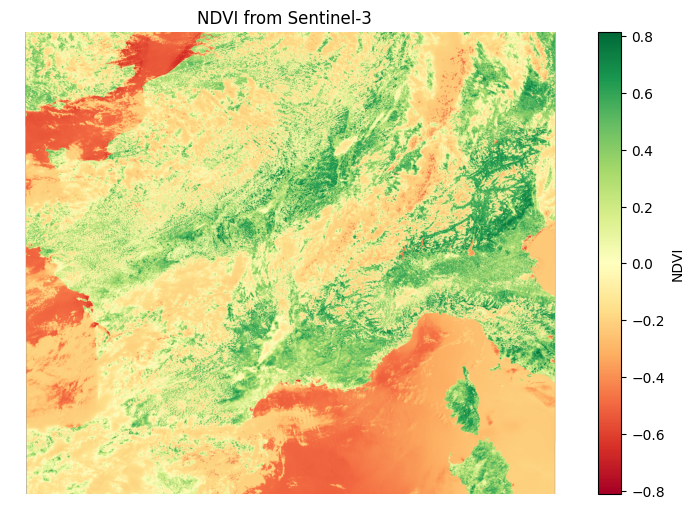

In [45]:
# Calculate NDVI
ndvi = (nir - red) / (nir + red)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title("NDVI from Sentinel-3")
plt.axis("off")
plt.show()


### RGB Composite Visualisation

To help visually interpret the land surface, I created a true-colour RGB composite by stacking the Sentinel-3 red, green, and blue bands in the standard order.  

The raw radiance values are normalized to the range [0, 1] to ensure consistent contrast and brightness for display.  

This visualization simulates how the scene would appear to the human eye, allowing us to clearly distinguish between vegetation (green areas), urban zones (gray or brown), and water (dark or bluish areas).


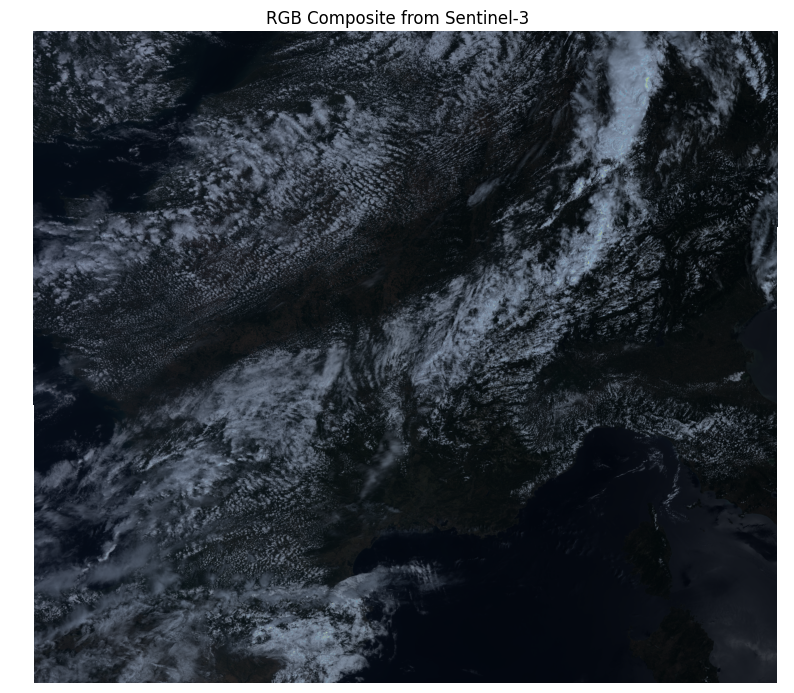

In [8]:
# Stack bands into RGB order: [Red, Green, Blue]
rgb = np.stack([
    red.values,
    green.values,
    blue.values
], axis=-1)

# Normalize to [0, 1] for display
rgb_min = np.nanmin(rgb)
rgb_max = np.nanmax(rgb)
rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min)

# Show RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.title("RGB Composite from Sentinel-3")
plt.axis("off")
plt.show()


## Land Use and Land Cover (LULC) Classification

This section forms the core of the project, where we classify land cover into distinct categories. We employ both unsupervised and supervised machine learning approaches and evaluate the resulting classifications through both qualitative visual comparison and quantitative statistical analysis.

In [46]:
# Make sure NDVI is a NumPy array (ndvi) and cleaned (remove NaNs):
ndvi_clean = np.nan_to_num(ndvi.values.astype('float32'))

In [47]:
# Reshape NDVI for clustering
h, w = ndvi_clean.shape
X = ndvi_clean.reshape(-1, 1)  # 1 feature (NDVI), many pixels

 ### K-Means Clustering (Unsupervised)

In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
label_image = labels.reshape(h, w)


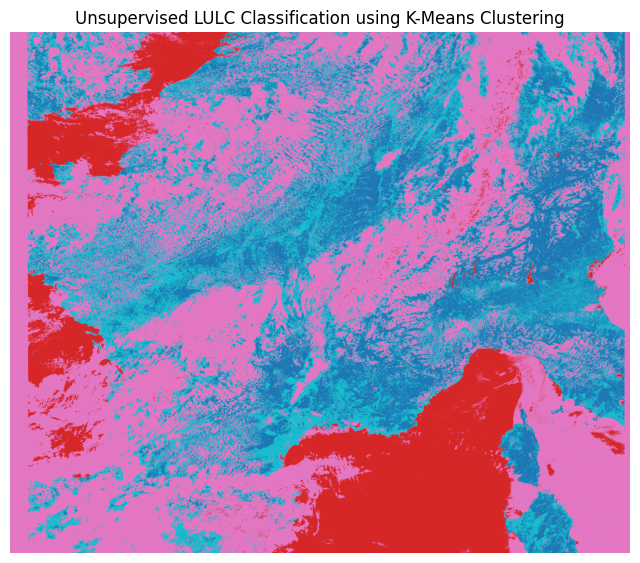

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(label_image, cmap='tab10')
plt.title("Unsupervised LULC Classification using K-Means Clustering")
plt.axis("off")
plt.show()


The presence of clouds is a major challenge when working with satellite imagery, particularly for unsupervised classification methods, which are sensitive to spectral outliers. Clouds obscure the land surface and introduce noise that can lead to misclassification or the formation of non-representative clusters. While cloud coverage can be reduced by selecting images from dates likely to have clear-sky conditions over the area of interest (AOI), complete removal is rarely achievable. Therefore, it is essential to assess the impact of residual cloud cover on classification accuracy.

In operational workflows, cloud masking algorithms such as **Fmask** or the use of Sentinel-2 **QA60** cloud bitmasks are often employed to detect and exclude cloudy pixels. However, for Sentinel-3 imagery, such preprocessed masks are less readily available, making manual filtering and temporal selection crucial for minimizing cloud interference in land cover analysis.


### Meaningful colour indicator

Unsupervised classification groups pixels based solely on spectral similarity, and the resulting output typically assigns arbitrary color codes to each cluster. These colors do not carry inherent meaning, which can make interpretation challenging. To improve visual clarity and aid in understanding the classification results, we can manually assign meaningful colors to each class based on their likely land cover types. For example, vegetation can be shown in green, water bodies in blue, clouds in grey, and built-up or bare soil areas in brown. This approach enhances the interpretability of unsupervised classification outputs, especially when comparing them with supervised results or high-resolution reference imagery.

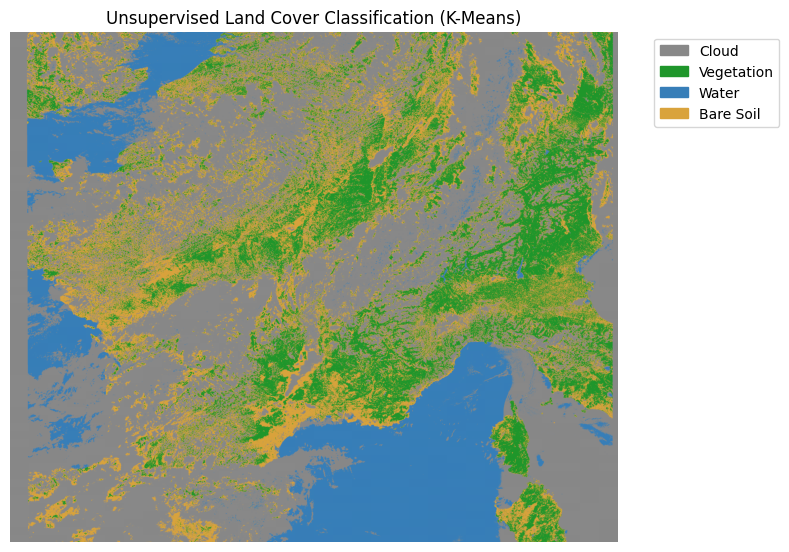

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

n_clusters = 4

cluster_to_label = {
    0: "Vegetation",
    1: "Water",
    2: "Cloud",
    3: "Bare Soil"
}

# Use meaningful colour for ground visualisation
custom_colors = {
    "Cloud": "#888888",
    "Vegetation": "#1f962b",
    "Water": "#377eb8",
    "Bare Soil": "#d9a33c"
}

# Build color map according to cluster-to-label mapping
cmap_list = [custom_colors[cluster_to_label[i]] for i in range(n_clusters)]
cmap = ListedColormap(cmap_list)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(label_image, cmap=cmap)
plt.title("Unsupervised Land Cover Classification (K-Means)")
plt.axis("off")

# Legend
patches = [mpatches.Patch(color=custom_colors[label], label=label) for label in custom_colors]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Supervised Machine Learning (Random Forest)

This section adapts the Random Forest classification method introduced in the AI4EO course. It brings together all components necessary for training a supervised machine learning model to distinguish between different land cover types based on pixel-level spectral features. Once the model is trained using manually labeled samples, it is applied to the entire image to generate a full-scene classification map. This projection enables the automatic labeling of every pixel in the image, based on the decision patterns learned during training.

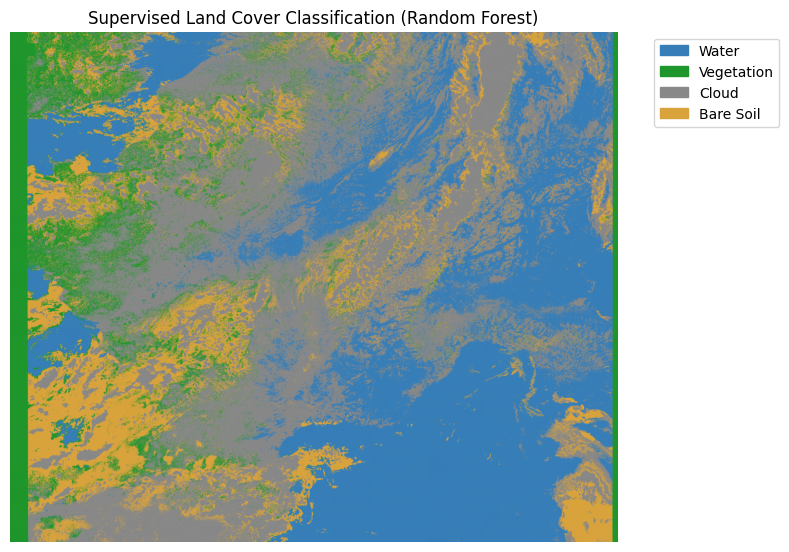

In [15]:
# RANDOM FOREST LAND COVER CLASSIFICATION

from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Preparation of features stack [Red, Green, Blue, NDVI]
features = np.stack([
    red.values,
    green.values,
    blue.values,
    ndvi.values
], axis=-1)

h, w, d = features.shape
X = features.reshape(-1, d)

# Step 2: Manually label sample pixels (small training patches)
y_mask = -1 * np.ones((h, w), dtype=int)

# Define 4 distinct regions across image
y_mask[3000:3100, 800:900] = 3   # Bare Soil
y_mask[100:200, 100:200] = 1     # Water
y_mask[1000:1100, 2000:2100] = 2 # Cloud
y_mask[3700:3800, 4000:4100] = 0 # Vegetation


# Step 3: Prepare training data
y_flat = y_mask.flatten()
train_idx = np.where(y_flat != -1)[0]
X_train = X[train_idx]
y_train = y_flat[train_idx]

# Step 4: Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Predict full image
y_pred = clf.predict(X)
classified_rf = y_pred.reshape(h, w)

# Step 6: Visualize classified result
class_labels = ["Water", "Vegetation", "Cloud", "Bare Soil"]
colors = ["#377eb8", "#1f962b", "#888888", "#d9a33c"]
cmap = ListedColormap(colors)

plt.figure(figsize=(8, 8))
plt.imshow(classified_rf, cmap=cmap)
patches = [mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Supervised Land Cover Classification (Random Forest)")
plt.axis("off")
plt.tight_layout()
plt.show()


### Qualitative Comparison

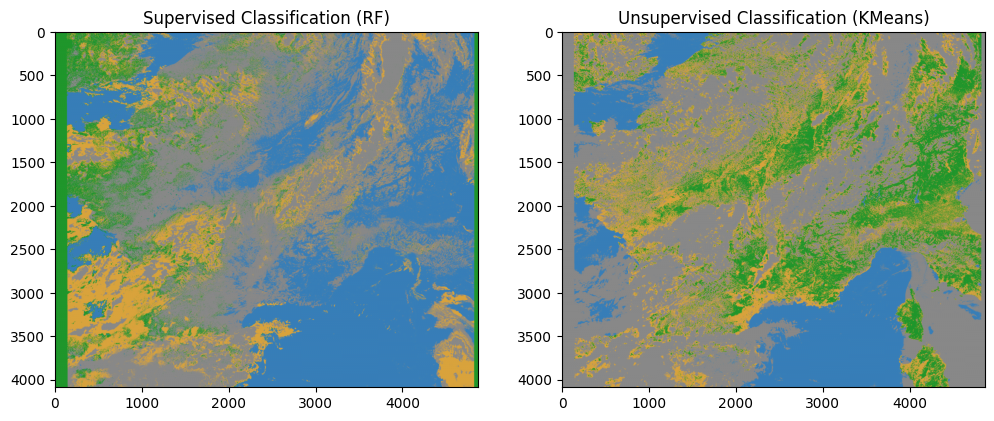

In [53]:
# Define a mapping from KMeans cluster ID to real class ID
cluster_to_class = {
    0: 1,  # cluster 0 → water
    1: 0,  # cluster 1 → vegetation
    2: 2,  # cluster 2 → built-up
    3: 3   # cluster 3 → cloud
}

# Apply the remapping
label_image_remapped = np.vectorize(cluster_to_class.get)(label_image)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(classified_rf, cmap=cmap)
ax[0].set_title("Supervised Classification (RF)")
ax[1].imshow(label_image_remapped, cmap=cmap)
ax[1].set_title("Unsupervised Classification (KMeans)")
plt.show()


### Quantitative Comparison

In [54]:
agreement = (label_image == classified_rf)
agreement_score = np.sum(agreement) / agreement.size
print(f"Pixel-wise agreement: {agreement_score:.2%}")

Pixel-wise agreement: 37.84%


Pixel-wise agreement measures how often two classification maps assign the same class label to the same pixel. It is calculated as the ratio of matching pixel values between two classification outputs over the total number of pixels.

In [28]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np

# Flatten predictions
pred1 = classified_rf.flatten()
pred2 = label_image.flatten()

# Build confusion matrix
conf_mat = confusion_matrix(pred1, pred2)

# Hungarian algorithm to find best mapping
row_ind, col_ind = linear_sum_assignment(-conf_mat)

# Map unsupervised labels to supervised
mapping = dict(zip(col_ind, row_ind))
aligned_pred2 = np.array([mapping[p] for p in pred2])

# Compute agreement after alignment
agreement_aligned = (pred1 == aligned_pred2).sum() / len(pred1)
print(f"Aligned Pixel-level Agreement: {agreement_aligned:.2%}")


Aligned Pixel-level Agreement: 41.00%


In [29]:
def class_distribution(pred, name):
    unique, counts = np.unique(pred, return_counts=True)
    print(f"{name} Class Distribution:")
    for u, c in zip(unique, counts):
        print(f"  Class {u}: {c} pixels")

class_distribution(classified_rf.flatten(), "Supervised")
class_distribution(label_image.flatten(), "Unsupervised")


Supervised Class Distribution:
  Class 0: 6390008 pixels
  Class 1: 2253334 pixels
  Class 2: 8276100 pixels
  Class 3: 2978408 pixels
Unsupervised Class Distribution:
  Class 0: 3420252 pixels
  Class 1: 2885901 pixels
  Class 2: 9420802 pixels
  Class 3: 4170895 pixels


## LULC Classification on second image

The same workflow will be applied to a second Sentinel-3 image to ensure consistency and assess the generalisability of the classification approach.

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/AI4EO W6_and_afterwards/Final Project/S3A_OL_1_EFR____20230707T104347_20230707T104647_20230709T020910_0179_100_379_1980_PS1_O_NT_003.SEN3.zip"
extract_dir = "/content/drive/MyDrive/AI4EO W6_and_afterwards/Final Project/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)


In [55]:
import xarray as xr
import os

sen3_path_im2 = "/content/drive/MyDrive/AI4EO W6_and_afterwards/Final Project/S3A_OL_1_EFR____20230707T104347_20230707T104647_20230709T020910_0179_100_379_1980_PS1_O_NT_003.SEN3"  # or the local folder path

# Load Red, Green, Blue, NIR
red   = xr.open_dataset(os.path.join(sen3_path_im2, 'Oa08_radiance.nc'))['Oa08_radiance']
green = xr.open_dataset(os.path.join(sen3_path_im2, 'Oa06_radiance.nc'))['Oa06_radiance']
blue  = xr.open_dataset(os.path.join(sen3_path_im2, 'Oa04_radiance.nc'))['Oa04_radiance']
nir   = xr.open_dataset(os.path.join(sen3_path_im2, 'Oa17_radiance.nc'))['Oa17_radiance']


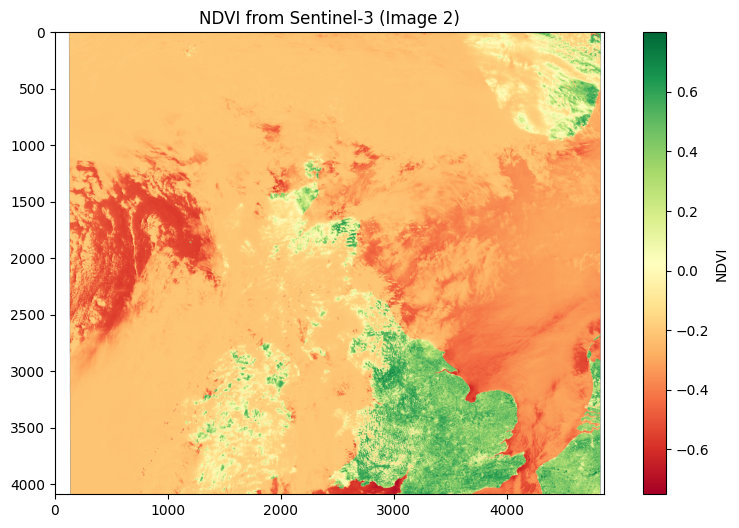

In [56]:
ndvi = (nir - red) / (nir + red)

plt.figure(figsize=(10, 6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title("NDVI from Sentinel-3 (Image 2)")
plt.axis("on")
plt.show()

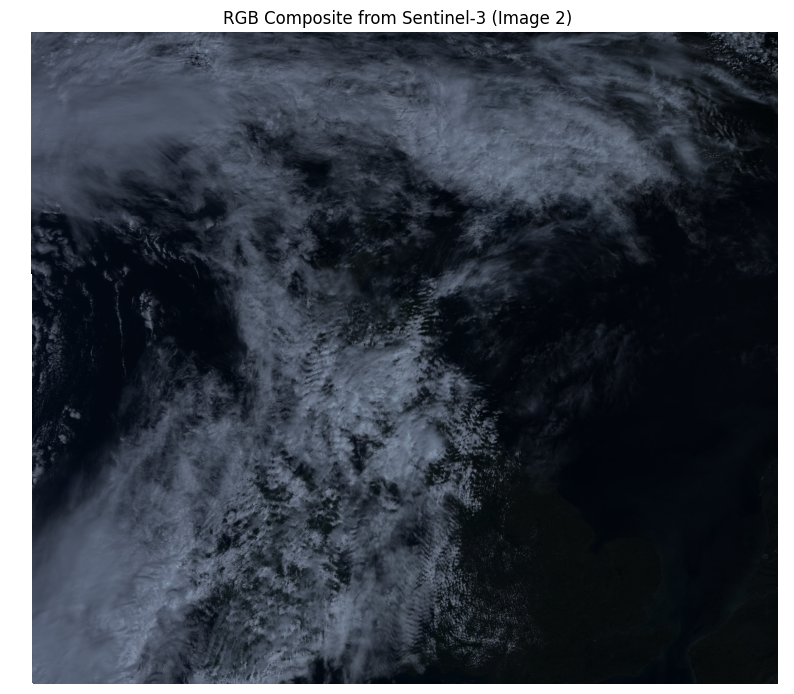

In [57]:
# Stack bands into RGB order: [Red, Green, Blue]
rgb = np.stack([
    red.values,
    green.values,
    blue.values
], axis=-1)

# Normalize to [0, 1] for display
rgb_min = np.nanmin(rgb)
rgb_max = np.nanmax(rgb)
rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min)

# Show RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.title("RGB Composite from Sentinel-3 (Image 2)")
plt.axis("off")
plt.show()

In [58]:
ndvi_clean_im2 = np.nan_to_num(ndvi.values.astype('float32'))

In [60]:
h, w = ndvi_clean_im2.shape
X = ndvi_clean_im2.reshape(-1, 1)  # 1 feature (NDVI), many pixels

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
label_image_im2 = labels.reshape(h, w)

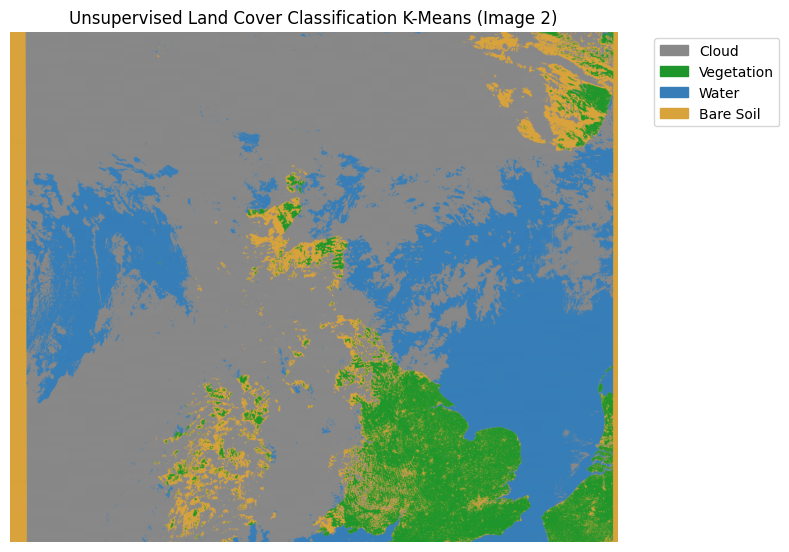

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

n_clusters = 4

cluster_to_label = {
    0: "Cloud",
    1: "Vegetation",
    2: "Water",
    3: "Bare Soil"
}

custom_colors = {
    "Cloud": "#888888",
    "Vegetation": "#1f962b",
    "Water": "#377eb8",
    "Bare Soil": "#d9a33c"
}

# Build color map according to cluster-to-label mapping
cmap_list = [custom_colors[cluster_to_label[i]] for i in range(n_clusters)]
cmap = ListedColormap(cmap_list)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(label_image_im2, cmap=cmap)
plt.title("Unsupervised Land Cover Classification K-Means (Image 2)")
plt.axis("off")

# Legend
patches = [mpatches.Patch(color=custom_colors[label], label=label) for label in custom_colors]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


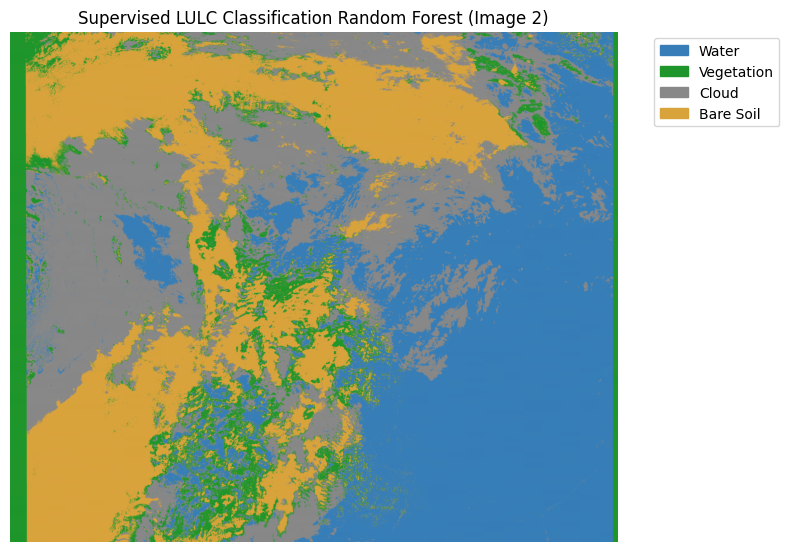

In [63]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Prepare feature stack [Red, Green, Blue, NDVI]
features = np.stack([
    red.values,
    green.values,
    blue.values,
    ndvi.values
], axis=-1)

h, w, d = features.shape
X = features.reshape(-1, d)

# Step 2: Manually label sample pixels (small training patches)
y_mask = -1 * np.ones((h, w), dtype=int)

# Define 4 distinct regions across image
y_mask[3000:3100, 800:900] = 3   # Bare Soil
y_mask[100:200, 100:200] = 1     # Water
y_mask[1000:1100, 2000:2100] = 2 # Cloud
y_mask[3700:3800, 4000:4100] = 0 # Vegetation


# Step 3: Prepare training data
y_flat = y_mask.flatten()
train_idx = np.where(y_flat != -1)[0]
X_train = X[train_idx]
y_train = y_flat[train_idx]

# Step 4: Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Predict full image
y_pred = clf.predict(X)
classified_rf_im2 = y_pred.reshape(h, w)

# Step 6: Visualize classified result
class_labels = ["Water", "Vegetation", "Cloud", "Bare Soil"]
colors = ["#377eb8", "#1f962b", "#888888", "#d9a33c"]
cmap = ListedColormap(colors)

plt.figure(figsize=(8, 8))
plt.imshow(classified_rf_im2, cmap=cmap)
patches = [mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Supervised LULC Classification Random Forest (Image 2)")
plt.axis("off")
plt.tight_layout()
plt.show()

### Qualitative Comparison (Image 2)

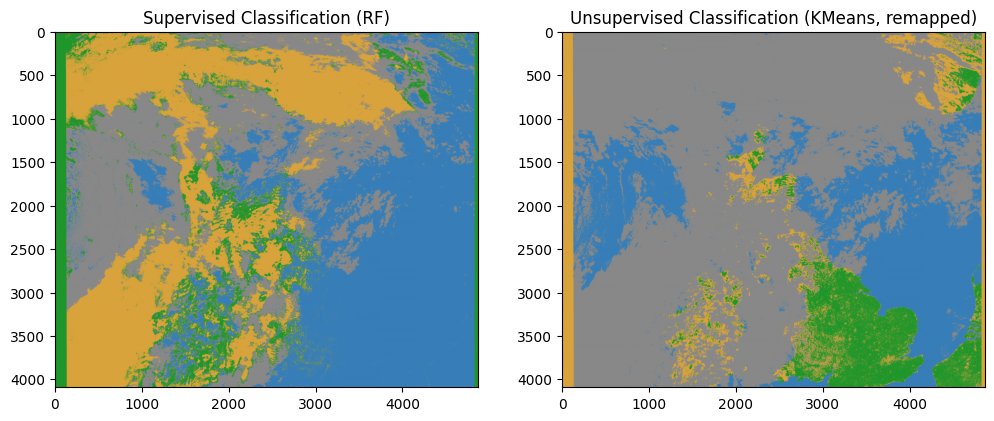

In [73]:
# Remapped colour for easier visual comparison
cluster_to_class_im2 = {
    0: 2,  # cluster 0 → cloud
    1: 1,  # cluster 1 → vegetation
    2: 0,  # cluster 2 → urban/bare soil
    3: 3   # cluster 3 → water
}

# Remap the KMeans output
label_image_im2_remapped = np.vectorize(cluster_to_class_im2.get)(label_image_im2)

# Plot with consistent colors
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(classified_rf_im2, cmap=cmap)
ax[0].set_title("Supervised Classification (RF)")
ax[1].imshow(label_image_im2_remapped, cmap=cmap)
ax[1].set_title("Unsupervised Classification (KMeans, remapped)")
plt.show()


### Quantitative Comparison (Image 2)

In [31]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np

# Flatten predictions
pred1 = classified_rf_im2.flatten()
pred2 = label_image_im2.flatten()

# Build confusion matrix
conf_mat = confusion_matrix(pred1, pred2)

# Hungarian algorithm to find best mapping
row_ind, col_ind = linear_sum_assignment(-conf_mat)

# Map unsupervised labels to supervised
mapping = dict(zip(col_ind, row_ind))
aligned_pred2 = np.array([mapping[p] for p in pred2])

# Compute agreement after alignment
agreement_aligned = (pred1 == aligned_pred2).sum() / len(pred1)
print(f"Aligned Pixel-level Agreement: {agreement_aligned:.2%}")

Aligned Pixel-level Agreement: 46.92%


In [33]:
def class_distribution(pred, name):
    unique, counts = np.unique(pred, return_counts=True)
    print(f"{name} Class Distribution:")
    for u, c in zip(unique, counts):
        print(f"  Class {u}: {c} pixels")

class_distribution(classified_rf_im2.flatten(), "Supervised")
class_distribution(label_image_im2.flatten(), "Unsupervised")

Supervised Class Distribution:
  Class 0: 6470879 pixels
  Class 1: 2135169 pixels
  Class 2: 5909641 pixels
  Class 3: 5387026 pixels
Unsupervised Class Distribution:
  Class 0: 11994751 pixels
  Class 1: 1695336 pixels
  Class 2: 4320816 pixels
  Class 3: 1891812 pixels
